In [1]:
#importataan tarvittavat kirjastot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import collections
import statistics
import graphviz

from sklearn import model_selection
from sklearn import tree

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


from sklearn.tree import DecisionTreeClassifier, export_text

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

   mileage        make   model      fuel    gear offerType  price     hp  year
0   235000         BMW     316    Diesel  Manual      Used   6800  116.0  2011
1    92800  Volkswagen    Golf  Gasoline  Manual      Used   6877  122.0  2011
2   149300        SEAT    Exeo  Gasoline  Manual      Used   6900  160.0  2011
3    96200     Renault  Megane  Gasoline  Manual      Used   6950  110.0  2011
4   156000     Peugeot     308  Gasoline  Manual      Used   6950  156.0  2011

NaN arvojen määrä:  0 

keskiverto      22970
edulliset       20540
kalliit          2272
superkalliit      289
Name: class, dtype: int64


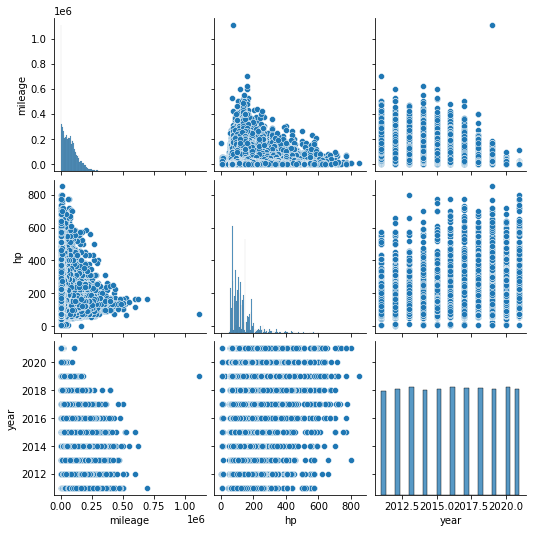

In [2]:
#luetaan data sisään
df = pd.read_csv("autoscout24-germany-dataset.csv", sep=",")
df_og = df

#pudotetaan dataframesta NaN arvot
df = df.dropna()

#tulostetaan ensimmäiset 5 riviä
print(df.head())

#tulostetaan nullien summa
print("\nNaN arvojen määrä: ", df.isnull().sum().sum(), "\n")

#määritellään autojen luokkien hintarajat
bins=[0,10000,40000,100000,1200000]

#nimetään luokat
group_names = ['edulliset','keskiverto','kalliit','superkalliit']

#luodaan dataframeen uusi luokka class, johon on määritelty yllänimetyt luokat
df['class'] = pd.cut(df.price,bins,labels=group_names)

#pudotetaan hinta attribuutti pois dataframesta
df = df.drop(['price'], axis=1)
# a = df.iloc[:, [0,1,2,3,4,5,6,7]]
#tulostetaan luokat ja niiden lukumäärät
classes = df['class'].value_counts()
print(classes)
sns.pairplot(df)

In [3]:
# enkoodataan string arvot integereiksi

car_encoder = OrdinalEncoder(dtype=int)
attribute_names = ['mileage','make', 'model', 'fuel', 'gear', 'offerType','hp','year']
encoded_data = car_encoder.fit_transform(df[attribute_names])


# laitetaan X muuttujaan ensimmäiset 8 saraketta
X = encoded_data[:, [0,1,2,3,4,5,6,7]] 

# muunnetaan X numpy taulukko muotoon
X = np.array(X)

# luodaan label encoder objekti.
le = LabelEncoder()
 
# 
# enkoodataan 'class' attribuutit numeeriseen muotoon
y = le.fit_transform(df['class'])
 
# tulostetaan y muuttuja testin vuoksi
print(y)

[0 0 0 ... 2 2 2]


In [4]:
#jaetaan data opetus ja testidataan suhteella 70/30
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=5)

Opetetaan gaussianNB malli ja selvitetään sen Accuracy score

In [5]:
#opetetaan gaussianNB malli ja selvitetään sen Accuracy score

classifier_gaussiannb = GaussianNB()
classifier_gaussiannb.fit(X_train, y_train)
y_pred = classifier_gaussiannb.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))

Accuracy score: 0.7926493995080307


In [6]:
nb_classifier = GaussianNB()
#parametrien hakua NB mallille
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,    
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 1.519911082952933e-07}

Opetetaan gaussian ja selvitetään sen Accuracy score parametrien kanssa

In [7]:
#opetetaan NB malli parametrien kanssa ja selvitetään sen Accuracy score

params = {'var_smoothing': 1.519911082952933e-07}
classifier_gaussiannb = GaussianNB(**params)
classifier_gaussiannb.fit(X_train, y_train)
y_pred = classifier_gaussiannb.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))

Accuracy score: 0.8154391549703371


[[5544    0  629    0]
 [   1  379  266   29]
 [1438  135 5292    0]
 [   0   53    0   56]]
0.8154391549703371


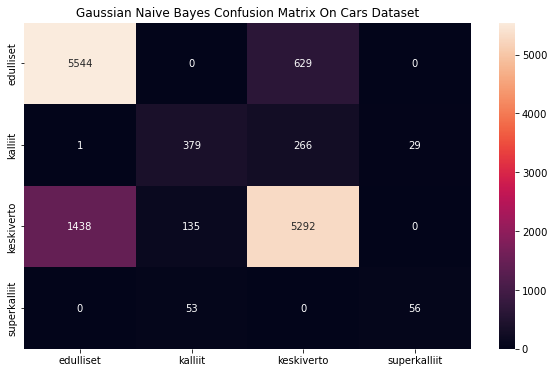

In [8]:

#
# luodaan confusion matriisi ja tulostetaan heatmäppinä NB luokitin
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

group_names_altered = ['edulliset','kalliit','keskiverto','superkalliit']

cm_df = pd.DataFrame(cm,group_names_altered,group_names_altered) 
plt.figure(figsize=(10,6))  
plt.title('Gaussian Naive Bayes Confusion Matrix On Cars Dataset')
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

In [9]:


# tehdään ristiin validointi ja lasketaan metriikat 
accuracy = model_selection.cross_val_score(classifier_gaussiannb, 
        X, y, scoring='accuracy', cv=5)
print("Accuracy of the classifier: " + str(round(100*accuracy.mean(), 2)) + "%")
print("Individual scores of the classifier: ",accuracy)

y_true = y

y_pred = classifier_gaussiannb.predict(X)
target_names = ['edulliset','kalliit','keskiverto','superkalliit']
print(classification_report(y_true, y_pred, target_names=target_names))



Accuracy of the classifier: 81.45%
Individual scores of the classifier:  [0.79967444 0.74788366 0.84577816 0.82830475 0.85077057]
              precision    recall  f1-score   support

   edulliset       0.80      0.90      0.85     20540
     kalliit       0.67      0.54      0.60      2272
  keskiverto       0.86      0.77      0.81     22970
superkalliit       0.71      0.61      0.66       289

    accuracy                           0.82     46071
   macro avg       0.76      0.71      0.73     46071
weighted avg       0.82      0.82      0.82     46071



In [18]:
#opetetaan malli ja tulostetaan tarkkuus jonka jälkeen tehdään päätöspuu ja tulostetaan se

classifier_DecisionTree = DecisionTreeClassifier(max_depth=4)
classifier_DecisionTree.fit(X_train, y_train)
y_test_pred = classifier_DecisionTree.predict(X_test)
accuracy = 100.0 * (y_test == y_test_pred).sum() / X_test.shape[0]
print("Accuracy of the classifier =", round(accuracy, 2), "%\n")
tree = export_text(classifier_DecisionTree, feature_names= \
                ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType','hp','year'])
print(tree)

Accuracy of the classifier = 82.91 %

|--- year <= 5.50
|   |--- hp <= 58.50
|   |   |--- hp <= 49.50
|   |   |   |--- hp <= 32.50
|   |   |   |   |--- class: 0
|   |   |   |--- hp >  32.50
|   |   |   |   |--- class: 0
|   |   |--- hp >  49.50
|   |   |   |--- mileage <= 13890.50
|   |   |   |   |--- class: 2
|   |   |   |--- mileage >  13890.50
|   |   |   |   |--- class: 0
|   |--- hp >  58.50
|   |   |--- year <= 1.50
|   |   |   |--- hp <= 91.50
|   |   |   |   |--- class: 0
|   |   |   |--- hp >  91.50
|   |   |   |   |--- class: 2
|   |   |--- year >  1.50
|   |   |   |--- hp <= 71.50
|   |   |   |   |--- class: 2
|   |   |   |--- hp >  71.50
|   |   |   |   |--- class: 2
|--- year >  5.50
|   |--- hp <= 111.00
|   |   |--- hp <= 30.50
|   |   |   |--- year <= 8.50
|   |   |   |   |--- class: 0
|   |   |   |--- year >  8.50
|   |   |   |   |--- class: 2
|   |   |--- hp >  30.50
|   |   |   |--- mileage <= 15469.50
|   |   |   |   |--- class: 2
|   |   |   |--- mileage >  15469.5

In [11]:
#haetaan optimaaliset hyperparametrit päätöspuulle annetuista vaihtoehdoista ja tulostetaan scoret eri parametreilla
parameter_rand = {
                  'criterion':['gini','entropy'],
                  'max_depth': [2,4,6,8,10 ],
                  'max_features': ['log2','sqrt','auto']}
                  
                 
metrics = ['precision']
for metric in metrics:
    print("#### Randomized Searching optimal hyperparameters for", metric)
    classifier = RandomizedSearchCV(DecisionTreeClassifier(), 
             param_distributions=parameter_rand,n_iter=30,           
             cv=5,return_train_score=True)
    classifier.fit(X_train, y_train)
    print("Scores across the parameter grid:")
    RandSCVResults = pd.DataFrame(classifier.cv_results_)
    for i in range(0,len(RandSCVResults)):
         print(RandSCVResults.params[i], '-->', 
                 round(RandSCVResults.mean_test_score[i],3))

print("Highest scoring parameter set:", classifier.best_params_)

#### Randomized Searching optimal hyperparameters for precision
Scores across the parameter grid:
{'max_features': 'log2', 'max_depth': 2, 'criterion': 'gini'} --> 0.709
{'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini'} --> 0.715
{'max_features': 'auto', 'max_depth': 2, 'criterion': 'gini'} --> 0.754
{'max_features': 'log2', 'max_depth': 4, 'criterion': 'gini'} --> 0.81
{'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini'} --> 0.794
{'max_features': 'auto', 'max_depth': 4, 'criterion': 'gini'} --> 0.789
{'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini'} --> 0.829
{'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini'} --> 0.816
{'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'} --> 0.822
{'max_features': 'log2', 'max_depth': 8, 'criterion': 'gini'} --> 0.86
{'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'} --> 0.845
{'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'} --> 0.839
{'max_features': 'log2', 'max_depth': 10

Luokitellaan uuden listan mukaisia autoja hintaluokkiin päätöspuulla

In [12]:
#ladataan uutta autodataa sisään jolla testataan mallin toimivuutta "tuntemattomilla arvoilla"
df_new_car_another = pd.read_csv('new_car_details.csv',sep=",")
#pudotetaan hinta attribuutti pois
df_new_car_another = df_new_car_another.drop(['price'], axis=1)
#opetetaan decision tree malli parhailla parametreilla
params = {'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}
classifier = DecisionTreeClassifier(**params)
classifier.fit(X_train, y_train)
attributes = ['mileage','make', 'model', 'fuel', 'gear', 'offerType','hp','year']
encoded_data_new = car_encoder.transform(df_new_car_another[attributes])

X_car_details = df_new_car_another.iloc[:, [0,1,2,3,4,5,6,7]]
#tulostetaan "tuntemattoman datan arvot"
print(X_car_details)

#luokitellaan uusi data käyttäen decision tree luokittelijaa

ynew_another_pred= classifier.predict(encoded_data_new)
for index, i in enumerate(ynew_another_pred):
    if i==0: print('Auton',index,'luokka: edulliset')    
    elif i==1: print('Auton',index,'luokka: kalliit')
    elif i==2: print('Auton',index,'luokka: keskiverto')
    else: print('Auton',index,'luokka: superkalliit')

   mileage        make  model      fuel       gear       offerType   hp  year
0    92800  Volkswagen   Golf  Gasoline     Manual            Used  122  2011
1   235000         BMW    316    Diesel     Manual            Used  116  2011
2       10         BMW     X2  Gasoline  Automatic  Pre-registered  178  2021
3   115000       Mazda      3  Gasoline  Automatic            Used  150  2011
4    31420        Audi  RS Q3  Gasoline  Automatic            Used  400  2020
Auton 0 luokka: edulliset
Auton 1 luokka: edulliset
Auton 2 luokka: keskiverto
Auton 3 luokka: keskiverto
Auton 4 luokka: kalliit


Luokitellaan uuden listan mukaisia autoja hintaluokkiin GaussianNB:llä

In [13]:
#ladataan sama "uusi" autodata sisään jolla testataan mallin toimivuutta "tuntemattomilla arvoilla"
df_new_car = pd.read_csv('new_car_details.csv',sep=",")
#pudotetaan hinta attribuutti pois
df_new_car = df_new_car.drop(['price'], axis=1)
encoded_data_second = car_encoder.transform(df_new_car[attributes])
X_car_another_details = df_new_car.iloc[:, [0,1,2,3,4,5,6,7]]
#luokitellaan sama "uusi" data käyttäen NB luokitinta
ynew_another_pred_second= classifier_gaussiannb.predict(encoded_data_second)
print(X_car_another_details)
print('\n*******************************************************************\nEnnusteet uusille autoille\n')
for index, i in enumerate(ynew_another_pred_second):
    if i==0: print('Auton',index,'luokka: edulliset')    
    elif i==1: print('Auton',index,'luokka: kalliit')
    elif i==2: print('Auton',index,'luokka: keskiverto')
    else: print('Auton',index,'luokka: superkalliit')

   mileage        make  model      fuel       gear       offerType   hp  year
0    92800  Volkswagen   Golf  Gasoline     Manual            Used  122  2011
1   235000         BMW    316    Diesel     Manual            Used  116  2011
2       10         BMW     X2  Gasoline  Automatic  Pre-registered  178  2021
3   115000       Mazda      3  Gasoline  Automatic            Used  150  2011
4    31420        Audi  RS Q3  Gasoline  Automatic            Used  400  2020

*******************************************************************
Ennusteet uusille autoille

Auton 0 luokka: edulliset
Auton 1 luokka: edulliset
Auton 2 luokka: keskiverto
Auton 3 luokka: edulliset
Auton 4 luokka: kalliit


In [20]:
# rakennetaan decisiontree luokittelija
params = {'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}
classifier = DecisionTreeClassifier(**params)
classifier.fit(X_train, y_train)

# tehdään ristiin validointi sekä tulostetaan accuracy score 
accuracy = model_selection.cross_val_score(classifier, 
        X, y, scoring='accuracy', cv=5)
print("Accuracy of the classifier: " + str(round(100*accuracy.mean(), 2)) + "%")

y_true = y
#tulostetaan luokitteluraportti
y_pred = classifier.predict(X)
target_names = ['edulliset','kalliit','keskiverto','superkalliit']
print(classification_report(y_true, y_pred, target_names=target_names))

Accuracy of the classifier: 86.53%
              precision    recall  f1-score   support

   edulliset       0.89      0.91      0.90     20540
     kalliit       0.80      0.73      0.76      2272
  keskiverto       0.89      0.89      0.89     22970
superkalliit       0.82      0.70      0.75       289

    accuracy                           0.89     46071
   macro avg       0.85      0.81      0.83     46071
weighted avg       0.89      0.89      0.89     46071



Tulostetaan päätöspuusta helpommin luettava kuva

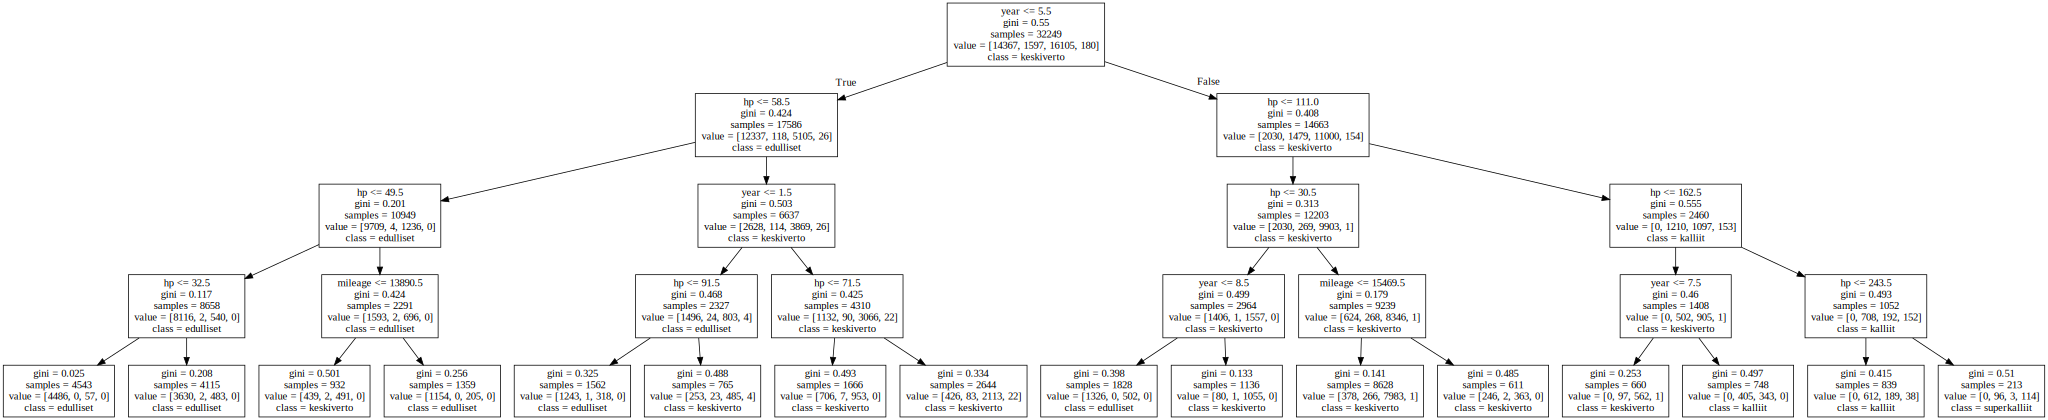

In [15]:
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree

gra = tree.export_graphviz(classifier_DecisionTree,
                out_file=None,
                feature_names=attributes,
                class_names=list(group_names_altered))
graph = graphviz.Source(gra, format="png") 
graph

[[5655    0  518    0]
 [   1  426  235   13]
 [ 760  109 5996    0]
 [   0   50    2   57]]
0.877875850094053


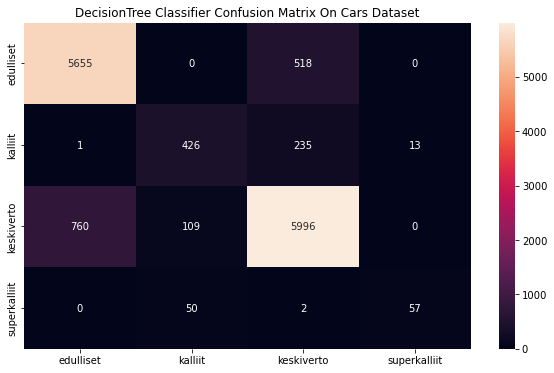

In [16]:
#
# luodaan confusion matriisi ja tulostetaan heatmäppinä decisiontree luokittelija
params = {'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}
classifier = DecisionTreeClassifier(**params)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

group_names_altered = ['edulliset','kalliit','keskiverto','superkalliit']

cm_df = pd.DataFrame(cm,group_names_altered,group_names_altered) 
plt.figure(figsize=(10,6))  
plt.title('DecisionTree Classifier Confusion Matrix On Cars Dataset')
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()